In [1]:
from montecarlo_lib import *  # Here we have implemented the Monte-Carlo Tree Search algorithm 
                              # as well as defining the rules of Checkers.

import matplotlib.pyplot as plt

import ipywidgets
from ipywidgets import interact, IntSlider, Button
from IPython.display import display

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.models import model_from_json


import tensorflow as tf 


%matplotlib inline

from pylab import rcParams

import time

Using TensorFlow backend.


In [27]:
!pip install edward

    100% |████████████████████████████████| 92kB 1.8MB/s ta 0:00:01
distributed 1.21.8 requires msgpack, which is not installed.
grin 1.2.1 requires argparse>=1.1, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:

class PolicyChooser:
    def __init__(self, starting_game, policy0, policy1, num_games = 5):
        self.policy0 = policy0
        self.policy1 = policy1
        self.starting_game = starting_game
        self.num_games = num_games
        
    def BestPolicy(self, verbose = False):
        games_list = []
        winners_list = []
        all_game_trees_list = []
        for game_num in range(self.num_games):
            game = deepcopy(self.starting_game)

            game_states_list = []
            game_trees_list = []
            if verbose:
                print("Game %d commencing." % game_num)
            
            
            for i in range(max_turns):
                num_actions = game.num_actions()     
                game.notes = ''
                game.notes += 'Turn %d: Player %d now choosing action from board above.\n' %  (i, game.player)
                game_to_play = deepcopy(game)
                game_to_play.max_turns = 60 #This setting stops stalling-for-time strategies

                if game.player == 0:
                    policy = self.policy0
                elif game.player == 1:
                    policy = self.policy1
                
                action = policy.play(game)

                if action is None:
                    game.notes +=  "No good move.  Taking random action.\n"
                    #print(game.notes)
                    action = game.random_action()

                game_states_list.append(deepcopy(game))
                (observation, reward, done, info) = game.step(action)        


                if done:
                    winner = game.winner()

                    if winner == 'draw':
                        note = "Game is a draw."
                    else:
                        note = 'Player %d wins! (after %d moves)' % (game.winner(), i)
                    game.notes = note
                    if verbose:
                        print(note)
                    winners_list.append(game.winner())
                if done:
                    game_states_list.append(deepcopy(game))
                    break
            else:
                if verbose:
                    print("Game timed out.")
                winners_list.append(None)

            games_list.append(deepcopy(game_states_list))
            all_game_trees_list.append(game_trees_list)
        if verbose:
            print(winners_list)
        
        
        self.games_list = games_list
        self.all_game_trees_list = all_game_trees_list
        self.winners_list = winners_list
        
        
        if winners_list.count(0) != winners_list.count(1):
            best_policy = argmax({0:winners_list.count(0), 1:winners_list.count(1)})
            print("Winner is policy %d with %d:%d wins" % (best_policy, winners_list.count(best_policy), winners_list.count(1-best_policy)   ))
        else:
            print("Tie!!")
            best_policy = np.random.randint(2)
            
        self.best_policy = best_policy
        return best_policy

In [3]:
# load json and create model
layers = [30,30,30]
activations = ['relu', 'relu', 'relu']

model = Sequential()

input_dim = 72
for i in range(len(layers)):
    if activations is None:
        activation = 'relu'
    else:
        activation = activations[i]

    if i == 0:
        model.add(Dense(layers[i],  activation = activation, input_dim = input_dim))
    else:
        model.add(Dense(layers[i],  activation = activation))

model.add(Dense(3))
#model.add(Activation('softmax'))

model.add(Activation(tf.nn.softmax))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mean_squared_error'])




# load weights into new model
model.load_weights("checkersnet_2018-10-15.h5")
print("Loaded model from disk")

Loaded model from disk


In [4]:

max_turns = 100  #max number of turns allowed in a single game. (after that winner is the player with most pieces)
total_budget = 100
num_games = 20
num_training_steps = 10
simulation_policies = [RandomPolicy(), RandomPolicy()]
orderliness = 30
board_size = 6
num_simulations = 3
epochs = 300
layers = [30,30,30]
activations = ['relu', 'relu', 'relu']

symmetrize = True

starting_game = checkers_state(board_size = board_size, max_turns = max_turns, tiebreaker_rule = True)


In [5]:

simulation_policy = NeuralNetPolicy(model)

ai_opponent = MonteCarloTree(starting_game, 
                           budget = 400, 
                           num_simulations = 1, 
                           max_steps_to_simulate = max_turns,
                           simulation_policy = RandomPolicy(),
                           save_simulations = True)

In [6]:
def attempt_action(b):
    global game,R,actions,move_button,slider,game_history
    actions = game.get_action_space()

    action = slider.value
    if action < game.num_actions():
        game_history.append(game.step(action, inplace = False)[-1])
        game = game_history[-1]
        
        check_finish()
        while game.player == 1:
            #ai opponent to move
            time.sleep(1)
            R.widget.update()
            move_button.disabled = True
            move_button.description = "AI thinking..."
            action = ai_opponent.play(game)
            if action is None:
                game.notes +=  "No good move.  Taking random action.\n"
                #print(game.notes)
                action = game.random_action()
            
            game_history.append(game.step(action, inplace = False)[-1])
            game = game_history[-1]
        refresh_display()
        check_finish()
        if not game.is_done():
            move_button.disabled = False
            move_button.description = "Move!"
    else:
        print("invalid move!")
        
def set_difficulty(budget):
    global ai_opponent
    ai_opponent.difficulty = budget
        
def undo(x):
    #some argument x required to work for .on_click() but not used
    global game,game_history
    
    game_index = max([i for i in range(len(game_history[:-1])) if game_history[i].player == 0])
    
    game = game_history[game_index]
    game_history = game_history[:game_index+1]
    refresh_display()
    
def restart_game(b):
    global game,arrow_color,plt,ax,R,actions,move_button,slider
    game = checkers_state(board_size = board_size, max_turns = max_turns, tiebreaker_rule = True)
    refresh_display()
    slider.disabled = False
    move_button.disabled = False
    #     plt.clf()
#     ax.clear()
#     show_board(game, move = move, arrow_color = arrow_color)

def refresh_display(x = None, check = False):  
    #some argument x required to work for .observe() but not used
    global R,actions,slider,assist_checkbox
    actions = game.get_action_space()
    if len(actions) > 0:
        slider.max = len(actions) - 1
#     else:
#         slider.disabled = True
    R.widget.update()
    
def checkbox_click(x):
    global ai_assist,assist_checkbox,R
    ai_assist = assist_checkbox.value
    R.widget.update()
    #print (ai_assist)
    #refresh_display()
    
def change_difficulty(x):
    global difficulty_box, ai_opponent
    ai_opponent.budget = difficulty_box.value

def check_finish():
    global game,move_button,slider
    if game.is_done():
        winner = game.winner()
        if winner == 0:
            print("You win!!")
        elif winner == 1:
            print("AI wins!!")
        elif winner == 'draw':
            print("DRAW!")
        #slider.disabled = True
        move_button.disabled = True
        move_button.description = "Game over"

In [7]:
rcParams['figure.figsize'] = 4,4

#fig, ax = plt.subplots()
game = checkers_state(board_size = board_size, max_turns = max_turns, tiebreaker_rule = True)
game_history = [checkers_state(board_size = board_size, max_turns = max_turns, tiebreaker_rule = True)]
ai_assist = False

actions = game.get_action_space()

move_button = Button(
    description="Move!",
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    icon=''
)

restart_button = Button(
    description="Restart"
)

undo_button = Button(
    description="Undo"
)


difficulty_box = ipywidgets.BoundedIntText(
    value=50,
    min=0,
    max=1000,
    step=1,
    description='AI difficulty:',
    disabled=False
)

assist_checkbox = ipywidgets.Checkbox(
    value=ai_assist,
    description='AI assist',
    disabled=False,
    indent = False
)

move_button.on_click(attempt_action)
restart_button.on_click(restart_game)
undo_button.on_click(undo)
assist_checkbox.observe(checkbox_click)
difficulty_box.observe(change_difficulty)

display(move_button)
display(undo_button)
display(restart_button)
display(difficulty_box)
display(assist_checkbox)

def f(Choose):
    i = Choose
    global arrow_color,valid_move,move_button,assist_checkbox,ai_assist,restart_button

#     if move_button.disabled:
#         return None
    
    if i < len(actions):
        action = actions[i]
        valid_move = True
    else:
        action = None
        valid_move = False
    

    if valid_move:
        game.show_board(move = action, arrow_color = 'green')
    else:
        game.show_board()
        
    if len(game_history) <= 1:
        undo_button.disabled = True
    else:
        undo_button.disabled = False
    
    if ai_assist and valid_move:
        nextmove_game = game.step(i, inplace = False)[-1]
        
        v = get_single_board_vector(nextmove_game, symmetrize = symmetrize)
        X = np.array([v])
        model_output = list(100 * model.predict(X)[0])

        if game.player == 1 and symmetrize:
            model_output = [model_output[1], model_output[0], model_output[2]]


        print("Chance victory with this action: ", model_output[0], '%')
        print("Chance of AI victory: ", model_output[1], '%')
        print("Chance of draw:             ", model_output[2], '%')


#R = interact(f, i = 0, min = 0, max = len(actions) - 1);
slider = IntSlider(min=0,max=len(actions) - 1,step=1,value=0)
R = interact(f, Choose=slider);

    #    (observation, reward, done, info) = game.step(action) 

Button(description='Move!', style=ButtonStyle())

Button(description='Undo', style=ButtonStyle())

Button(description='Restart', style=ButtonStyle())

BoundedIntText(value=50, description='AI difficulty:', max=1000)

Checkbox(value=False, description='AI assist', indent=False)

interactive(children=(IntSlider(value=0, description='Choose', max=4), Output()), _dom_classes=('widget-intera…

DRAW!


In [26]:
# child = ai_opponent.BestChild(ai_opponent.root, explore = False)
# #c = ai_opponent.tree[child]
# game_to_view = 0
# game_states_list = child.games[game_to_view] 
# rcParams['figure.figsize'] = 4,4

# def game_slider(i):
#     game_states_list[i].show_board()
    
#     v = get_single_board_vector(game_states_list[i])
#     X = np.array([v])
#     model_output = list(100 * model.predict(X)[0])
#     #print(game_states_list[i].notes)
#     print("Chance of Player 0 victory: ", model_output[0], '%')
#     print("Chance of Player 1 victory: ", model_output[1], '%')
#     print("Chance of draw:             ", model_output[2], '%')
#     return 'Player: %d' % game_states_list[i].player

# interact(game_slider, i = IntSlider(min=0,max=len(game_states_list)-1,step=1,value=0))



interactive(children=(IntSlider(value=0, description='i', max=3), Output()), _dom_classes=('widget-interact',)…

<function __main__.game_slider(i)>

starting from:


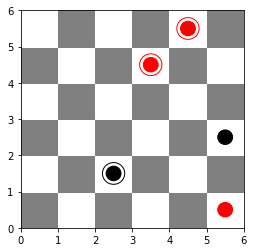

1


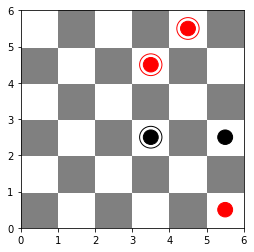

action: 0 ie. ((2, 1), (3, 2))
len: 58 expected: 58
Num player ai losses: 29
Num player ai victories: 9
value: 0.3275862068965517
2


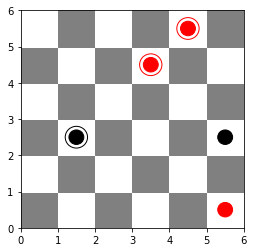

action: 1 ie. ((2, 1), (1, 2))
len: 19 expected: 19
Num player ai losses: 15
Num player ai victories: 1
value: 0.13157894736842105
3


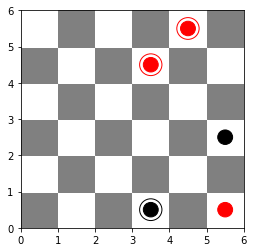

action: 2 ie. ((2, 1), (3, 0))
len: 66 expected: 66
Num player ai losses: 27
Num player ai victories: 9
value: 0.36363636363636365
4


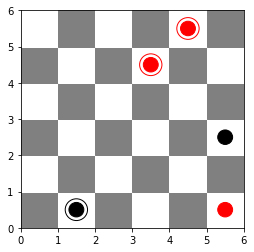

action: 3 ie. ((2, 1), (1, 0))
len: 53 expected: 53
Num player ai losses: 27
Num player ai victories: 7
value: 0.3113207547169811
5


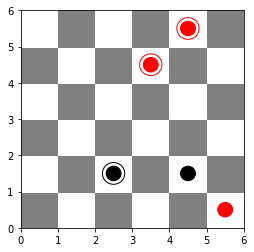

action: 4 ie. ((5, 2), (4, 1))
len: 4 expected: 4
Num player ai losses: 0
Num player ai victories: 0
value: 0.5


In [14]:
# print("starting from:")
# ai_opponent.root.state.show_board()

# for i in ai_opponent.root.children:
#     print(i)
#     child = ai_opponent.tree[i]
#     child.state.show_board()
#     print('action:', child.action, 'ie.', ai_opponent.root.state.get_action_from_int(child.action))
#     print('len:', len(child.all_simulation_results), 'expected:',child.N)
#     print('Num player ai losses:', child.all_simulation_results.count(0))
#     print('Num player ai victories:', child.all_simulation_results.count(1))
#     print('value:', child.Q/child.N)